## SLAM-Particle Filter for Qubits under Dephasing

The purpose of this workbook is to apply *qslam* to infer a uniform dephasing noise field from single-qubit Ramsey measurements performed on a grid of qubits.

First, we import the relevant packages

In [1]:
import sys
sys.path.append('../')
from qslam.preamble import *

#### Physical Device 
We assume that a physical device consists of a fixed grid of qubits. The location of a qubit on the grid is known and described in terms of grid-coordinates. For example, we specify a 5x5. grid of 20 qubits below: 

In [2]:
x_grid=20
y_grid=20
devicegrid = [x_grid, y_grid] # only square grids for now

#### True Dephasing

We now create a  dephasing noise field over this grid. In simulation, at each grid point, we define the derivative of the phase noise field that needs to be inferred using single qubit measurements:

In [3]:
uniform_map = np.ones((x_grid, y_grid))*np.pi*0.5
leftgradient_map = np.ones((x_grid, y_grid))*np.linspace(0, np.pi, x_grid)
cornergradient_map  = 0.5*(leftgradient_map + leftgradient_map.T)

radials = np.zeros((x_grid, y_grid))
for idx in xrange(int(x_grid*0.5)):
    for idy in xrange(int(y_grid*0.5)):
        radials[idx, idy]= (idy**2 + idx**2)*np.pi*0.25/ 6**2

somemap_ = radials + radials[::-1, ::-1] + radials[:, ::-1] + radials[::-1, :] 

# uniform map, should yield Ramsey measurements 0 more frequently than 1
truth = TrueMap(m_vals=somemap_)

#### Control Positions and Scan Ranges

Next, we want to set up a measurement protocol. In code, this means we specify the sequence in which qubits are made available for a sensing measurement. We call these 'controls' as one can imagine that the availbility of qubits on the grid is analogous to telling a 'robot' where to go next in a SLAM framework. 

In [4]:
controls = [(2, 2, 2.)]*3  + [(12, 12, 4.)]*1 + [(6, 18, 0.)]*5 + [(18, 6, 2.)]*5
print("Control sequence will take measurements at the following locations:")
print [(idx[0], idx[1]) for idx in controls]

Control sequence will take measurements at the following locations:
[(2, 2), (2, 2), (2, 2), (12, 12), (6, 18), (6, 18), (6, 18), (6, 18), (6, 18), (18, 6), (18, 6), (18, 6), (18, 6), (18, 6)]


Why is there a third parameter in each control? The third parameter refers to how measurement information at a location (x,y) is "blurred" over the neighbours of (x,y). This is called a 'scan range' - a correlation length that spreads information under the assumption that dephasing noise fields are continuously varying in space. For the controls above, the scan ranges are:

In [5]:
print("Control sequence will blurr information to nearest neighbours within a correlation length:")
print [(idx[2]) for idx in controls]

Control sequence will blurr information to nearest neighbours within a correlation length:
[2.0, 2.0, 2.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0]


As more measurements are taken, a histogram of qubit measurements at each location is the sample-estimate of the true Born probability of observing a '1' on the qubit, and hence can be used to infer the dephasing noise field. However, we want to minimise the amount of measurements taken, and 'blurring' a data point over its neighbours allows us to use 'quasi-measurement' information to infer true dephasing noise. 

#### Initiating SLAM using a Particle Filter

The true state being estimated is the qubit state under a dephasing noise field, namely, we wish to estimate and track the derivative of the phase noise field and compare it to the true map specified for the device.

qslam has been implemented as a particle filter to accomodate non-linear system descriptions and to accomodate the quasi-measurement (blurring) feature. A particle filter requires the user to specify the total number of particles used to approximate the probability distribution (posterior) describing the true state of the system. Changing the number of particles in a particle filter improves the variance on the true state estimates - for a test run with uniform dephasing, it's sufficient to get true state estimates with only 1 particle.

In [6]:
particle_num=10

The SLAM framework is initiated for a given device as follows:

In [7]:
slamize = ParticleFilter(num_p=particle_num, localgridcoords_=devicegrid)

The code above sets up a particle filter SLAM framework. 

In this framework:

1. Phyiscal Device :: *devicegrid* :: defined by grid coordinates; a qubit sits on each grid node. Currently only square grids considered. 
2. Sensing Qubit :: *globalbot* :: defined as a **robot**, with a **map** and **scanner**. Robot positions are given as grid coordinates; availability of a sensing qubit is modelled as the movement of a robot from one location to another, specified by *controls* (perfectly). Scanner makes a single physical measurement at a location; then uses the physical measurement to generate a number of quasi-measurements over its nearest neighbours. Physical and quasi measurements are passed on the particle filter. (We assumes that only one sensing qubit is available on the grid at any given time.) The map of the Sensing Qubit is updated using only physical measurements (no quasi-msmts are used).  
3. Particle Filter :: *single particle* :: defined as a **robot**, with a **map**, and a one-step-ahead **predictor**. Robot (particle) position is inherited from the Sensing Qubit. Particle map and predictor are used to make one-step ahead predictions at the current location and its nearest neighbours. This predicted region is compared with physical msmt and quasi measurement data from the Sensing Qubit. The residuals over the entire region are used to calculate a weight (likelihood) for the robot (particle). 
4. Particle Filter :: *posterior map* :: returns posterior map. State information is combined across particles - such that a highly likely particles contribute more information to the overall posterior. 

The above framework is completely general. Note that initiation only requires the user to specify the number of particles.

#### Running qslam

We run qslam using the *qslam_run* method, for a simulated dephasing noise map and a given control path:

In [8]:
# %%timeit
with suppress_stdout():
    slamize.qslam_run(truth, controls) # predictions function can't handle rectangular grids

../qslam/sensing.py:149: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  born_est = self.r_questbk[pose_x, pose_y]
../qslam/particle.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  predictions.append(self.r_measure(np.nan_to_num(self.m_vals[pred_x, pred_y])))# this needs to cope for missing data
../qslam/particle.py:88: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  prob = self.r_questbk[u_x, u_y] # this will be not Nan if the previous loop is completed
../qslam/particle.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.m_vals[u_x, u_y] = self.get_phase_method(prob) # this will update a nan value to a number


#### Results

The key check for any simulation is that the map of Sensing Qubit (*globalbot*, based on physical measurements) and posterior map of Particle Filter are identical in the limit of infinite measurements and zero quasi-measurement scan range. 

For finite, minimal measurements, quasi-measurement data allows particle filter to infer map faster.
We can calculate the squared error between the true and inferred maps, and re-scale error by the maximum possible value (pi^2)

In [11]:
# Global Bot
sample_born_est = np.asarray([slamize.particles[0].get_phase_method(val) for val in slamize.global_bot.r_questbk.flatten()]).reshape(x_grid,y_grid)
resid_globalbot = (truth.m_vals - sample_born_est)**2 / np.pi**2

# Particle Map
posterior=0.
for idx in range(particle_num):
    posterior += (1./particle_num)*slamize.particles[idx].m_vals
resid_posterior = (truth.m_vals - posterior)**2  / np.pi**2

Below, we plot the residual squared error maps (not RMS) for (a) globalbot and (b) posterior map from the particle filter, with respect to the true maps. Both should converge to zero error for infinite measurements, but the rate of convergence should be faster for (b). 

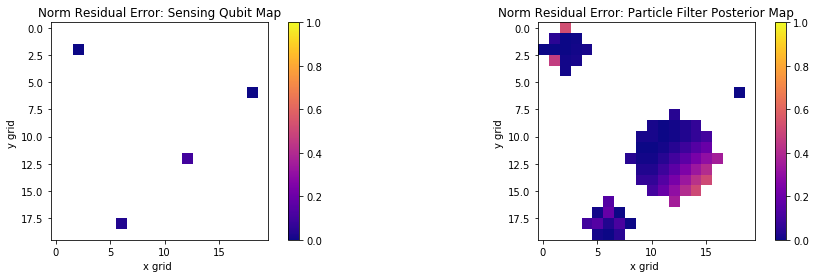

In [15]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('Norm Residual Error: Sensing Qubit Map')
plt.imshow(resid_globalbot, cmap='plasma', vmin=0, vmax=1.)
plt.colorbar()
plt.xlabel('x grid ')
plt.ylabel('y grid ')

plt.subplot(1,2,2)
plt.title('Norm Residual Error: Particle Filter Posterior Map')
plt.imshow(resid_posterior, cmap='plasma', vmin=0, vmax=1.)
plt.colorbar()
plt.xlabel('x grid ')
plt.ylabel('y grid ')

plt.show()


The actual maps of the derivative of the dephasing field corresponding to the plots above are:

All values lie in [0, pi] radians; representing derivative of phase noise field at qubit locations.


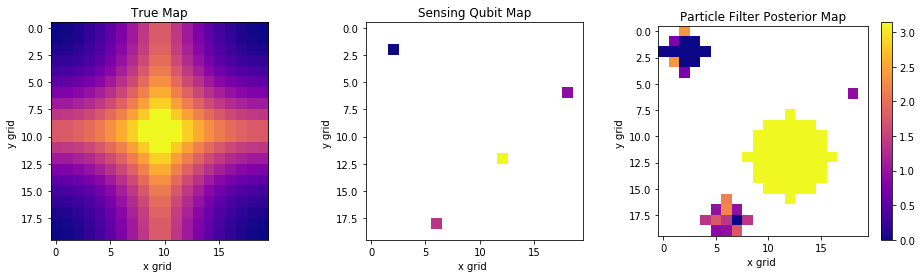

In [14]:
print('All values lie in [0, pi] radians; representing derivative of phase noise field at qubit locations.')

fig = plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.title('True Map')
ax1 = plt.imshow(truth.m_vals, cmap='plasma', vmin=0, vmax=np.pi)
plt.xlabel('x grid ')
plt.ylabel('y grid ')

plt.subplot(1,3,2)
plt.title('Sensing Qubit Map')
plt.imshow(sample_born_est, cmap='plasma', vmin=0, vmax=np.pi)

plt.xlabel('x grid ')
plt.ylabel('y grid ')

plt.subplot(1,3,3)
plt.title('Particle Filter Posterior Map')
plt.imshow(posterior, cmap='plasma', vmin=0, vmax=np.pi)

plt.xlabel('x grid ')
plt.ylabel('y grid ')

plt.colorbar(ax1)
plt.show()

'''
TEST SCRIPT

Type: Module testing
Original Script: slampf.py
Class: slampf.py
Methods: ALL
Details: Test slam output for single particle, single control, uniform map 
Outcome: SUCCESSFUL

1. Particle maps aren't updating  - FIXED
2. The guestbook for each particle is updating twice on each real msmt - FIXED
3. Add extended print statements to probe single particle, single control SLAM - DONE

Theory Qns: 
1. Are we doing better than randomly measuring qubits on the grid?
2. Is the likelihood function correct?
3. What is the threshold to stop the algorithm?
4. What happens if we average over the same region again and again? Do we lose info by averaging using the scanner?
5. What if we visit a qubit and it's four neighbours? Does the averaging process give us more or less info? 
6. For (5), is there a combination of physical and quasi msmts that are optimal? 
7. How does increasing the number of particles reduce state variance? Where does it flatline?
8. How do we compare global_bot, particle map and true maps?
9. Why does the particle map differentiate significantly from n=3 to n=4 msmts at the same spot (why not n=2)?
10. Need an extra control parameter to control the Gaussian blurring function. 
At the moment, the correlation length and the variance for the blur are the same. 
But the blurring kernel (and its hyperparams) should be tuned independently. 
11. Gaussian blurring needs to change (either by incorporating global_bot / reducing avergaing as more real data is avail)



'''

As measurements increase, the scan ranges can be reduced such that quasi-measurements have a lesser impact on the inference procedure compared to actual measurements. This diminsishing scan-range functionality has not yet been implemented

In fact, the treatment of re-observation in standard SLAM (such that all features become correlated over time) is displaced by the need for quasi-measurements in our application.  This means that the simultaneous mapping and localisation benefits that accrue from re-observing map features - are not being utilised.This is a key question that needs to be explored with more care.


Extensions (not implemented):

 - Every particle in the particle filter should have a randomised scan range, and the weighting procedure should pick out the most relevant scan range based on the likelihood function
 - Define what it means to "re-observe" a map feature in SLAM for this application - is there any benefit to doing SLAM?
 - Change the likelihood function based on second paper
 - Jitter in dephasing noise map ==> model this as imperfect knoweldge of robot position on the grid.
 - Time domain dynamics of map ==> add a temporal AR process to evolve the map at each time step
 
 
 
''' errors will never be symmetric for quasimeasurements for the case true map is 
all zeros (more errors) or all pi (less errors).

Asymmetric errors reduced by having more particles (to some extent)

'''
 